In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import SEACells
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ad = sc.read('SA501.h5ad')

print(ad.shape)
ad.var

(1152, 32738)


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


,gene_ids
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
AC145205.1,ENSG00000215635
BAGE5,ENSG00000268590
CU459201.1,ENSG00000251180
AC002321.2,ENSG00000215616


In [3]:
ad.obs['clone'] = ad.obs['Clone_Assignment']
print(ad.obs_names)
print(ad[:, :].to_df())
print(ad.obs['clone'])
ad.var_names

Index(['AAACCTGAGATGCCAG-1', 'AAACCTGTCGACAGCC-1', 'AAACCTGTCTTCAACT-1',
       'AAACGGGTCGTTGCCT-1', 'AAAGATGAGTGGTAGC-1', 'AAAGATGGTAATAGCA-1',
       'AAAGATGTCAACACTG-1', 'AAAGCAACATCTCCCA-1', 'AAAGCAAGTGAAGGCT-1',
       'AAAGTAGAGCTGAAAT-1',
       ...
       'TTTATGCGTTCAGGCC-1', 'TTTCCTCGTCCTGCTT-1', 'TTTGCGCCAAGTCTAC-1',
       'TTTGCGCCAATGGATA-1', 'TTTGCGCCAGACTCGC-1', 'TTTGCGCTCCAAGCCG-1',
       'TTTGGTTAGTAGCCGA-1', 'TTTGGTTCAGATGGCA-1', 'TTTGTCAAGCATGGCA-1',
       'TTTGTCATCTATCGCC-1'],
      dtype='object', length=1152)
                    MIR1302-10  FAM138A  OR4F5  RP11-34P13.7  RP11-34P13.8  \
AAACCTGAGATGCCAG-1         0.0      0.0    0.0           0.0           0.0   
AAACCTGTCGACAGCC-1         0.0      0.0    0.0           0.0           0.0   
AAACCTGTCTTCAACT-1         0.0      0.0    0.0           0.0           0.0   
AAACGGGTCGTTGCCT-1         0.0      0.0    0.0           0.0           0.0   
AAAGATGAGTGGTAGC-1         0.0      0.0    0.0           0.0       

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [4]:
ad.obs['clone'] = ad.obs['Clone_Assignment']

print(ad.obs['clone'].value_counts(normalize=True))

A    0.807292
B    0.166667
C    0.026042
Name: clone, dtype: float64


In [5]:
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

<Axes: xlabel='clone', ylabel='library_size'>

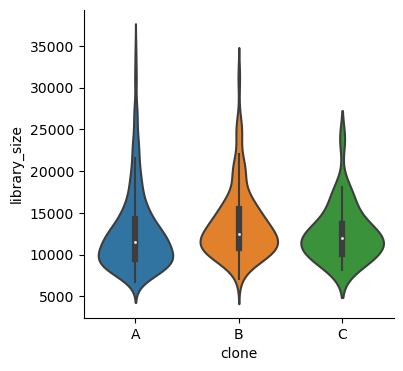

In [6]:
ad.obs['library_size'] = ad.X.sum(axis=1)
# Plot a violin plot of library size by clone
sns.violinplot(x='clone', y='library_size', data=ad.obs)

In [7]:
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1545)

In [8]:
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [9]:
# compute UMAP
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=50)
sc.tl.umap(ad)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


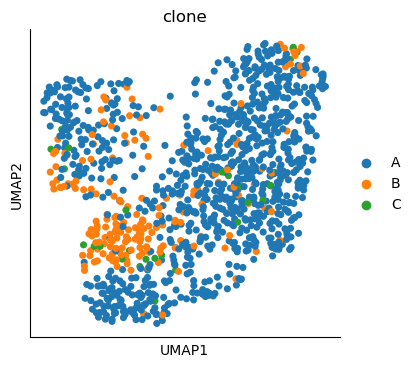

In [10]:
# Plot UMAP colored by clones
sc.pl.umap(ad, color='clone')

<Axes: xlabel='clone', ylabel='library_size'>

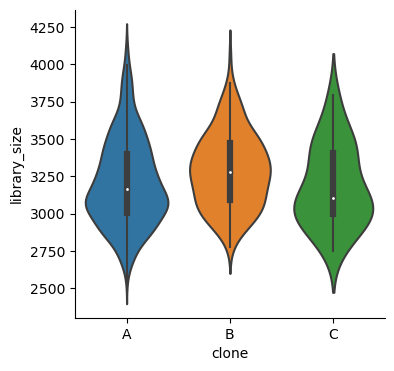

In [11]:
ad.obs['library_size'] = ad.X.sum(axis=1)
# Plot a violin plot of library size by clone
sns.violinplot(x='clone', y='library_size', data=ad.obs)

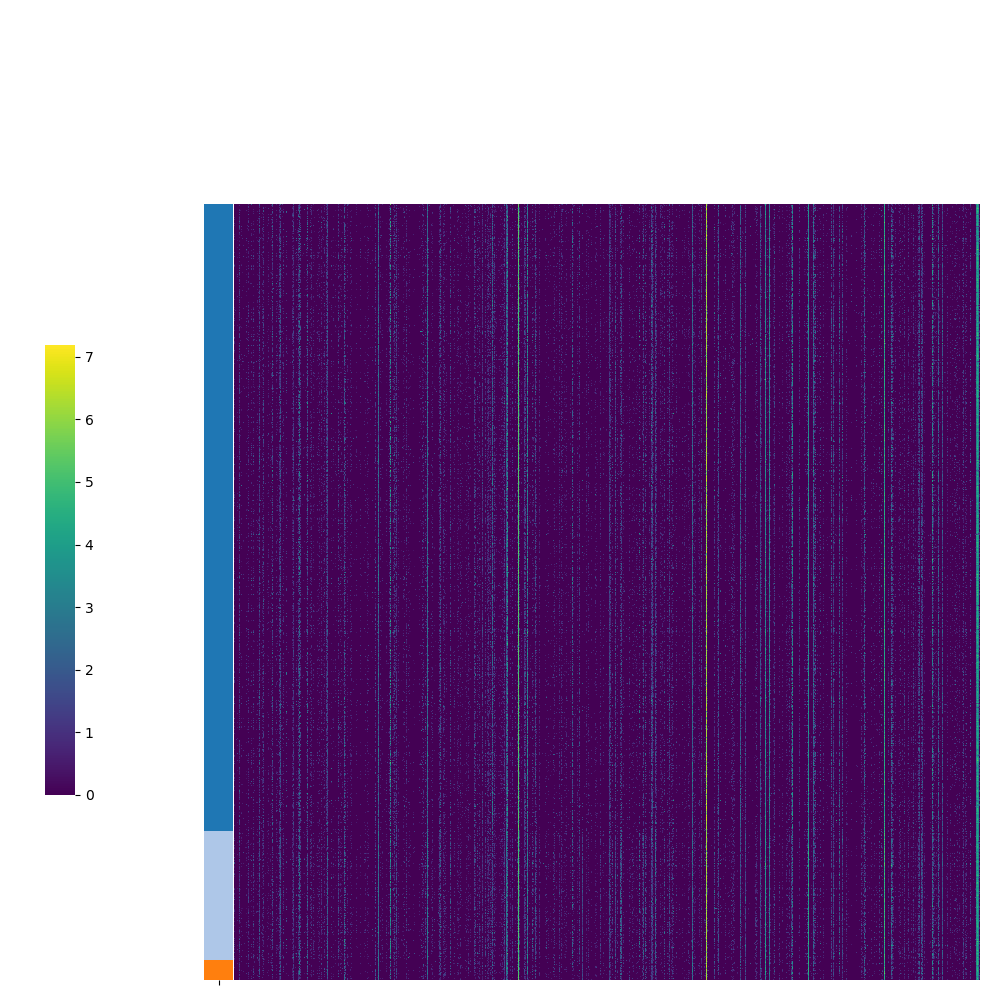

In [12]:
highly_variable_genes = ad.var[ad.var['highly_variable']]
df = ad[:, highly_variable_genes.index].to_df()
df['clone'] = ad.obs['clone']

# Sort the cells by clone
df = df.sort_values('clone')

unique_clones = df['clone'].unique()

clone_palette = sns.color_palette("tab20", n_colors=len(unique_clones))

# Map 'clone' categories to colors
clone_colors = {clone: color for clone, color in zip(unique_clones, clone_palette)}

# Apply the mapping to generate row colors for the clustermap
clone_series = df['clone']
color_list = [clone_colors[clone] if clone in clone_colors else None for clone in clone_series]

# Now, color_list contains the corresponding color for each entry in clone_series
# Verify the operation by converting color_list back to a Series and inspecting it
color_series = pd.Series(color_list, index=clone_series.index)

# Create the clustermap
data_df = df.drop('clone', axis=1)
g = sns.clustermap(data_df, method='average', metric='euclidean', 
                   figsize=(10, 10), row_cluster=False, col_cluster=False,
                   row_colors=color_series, cmap='viridis', 
                   yticklabels=False, # Often too cluttered, adjust as needed
                   xticklabels=False, # Adjust as needed
                   linewidths=0.0, rasterized=True)

# Adjust the position of the main color bar
g.cax.set_position([0.05, .2, .03, .45])

# Create a legend for the clones
for clone, color in clone_colors.items():
    g.ax_col_dendrogram.bar(0, 0, color=color, label=clone, linewidth=0)
g.ax_col_dendrogram.legend(title='Clone', loc="center", bbox_to_anchor=(0.5, -0.6), ncol=5, frameon=False)

plt.show()



In [90]:
ad

AnnData object with n_obs × n_vars = 1152 × 1545
    obs: 'Clone_Assignment', 'clone', 'library_size', 'n_counts'
    var: 'gene_ids'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'clone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

In [13]:
n_SEACells = ad.n_obs // 50
build_kernel_on = 'X_pca'
n_waypoint_eigs = 10

model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5,
                  use_sparse=True,)

Welcome to SEACells!


In [14]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/1152 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/1152 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/1152 [00:00<?, ?it/s]

Constructing CSR matrix...


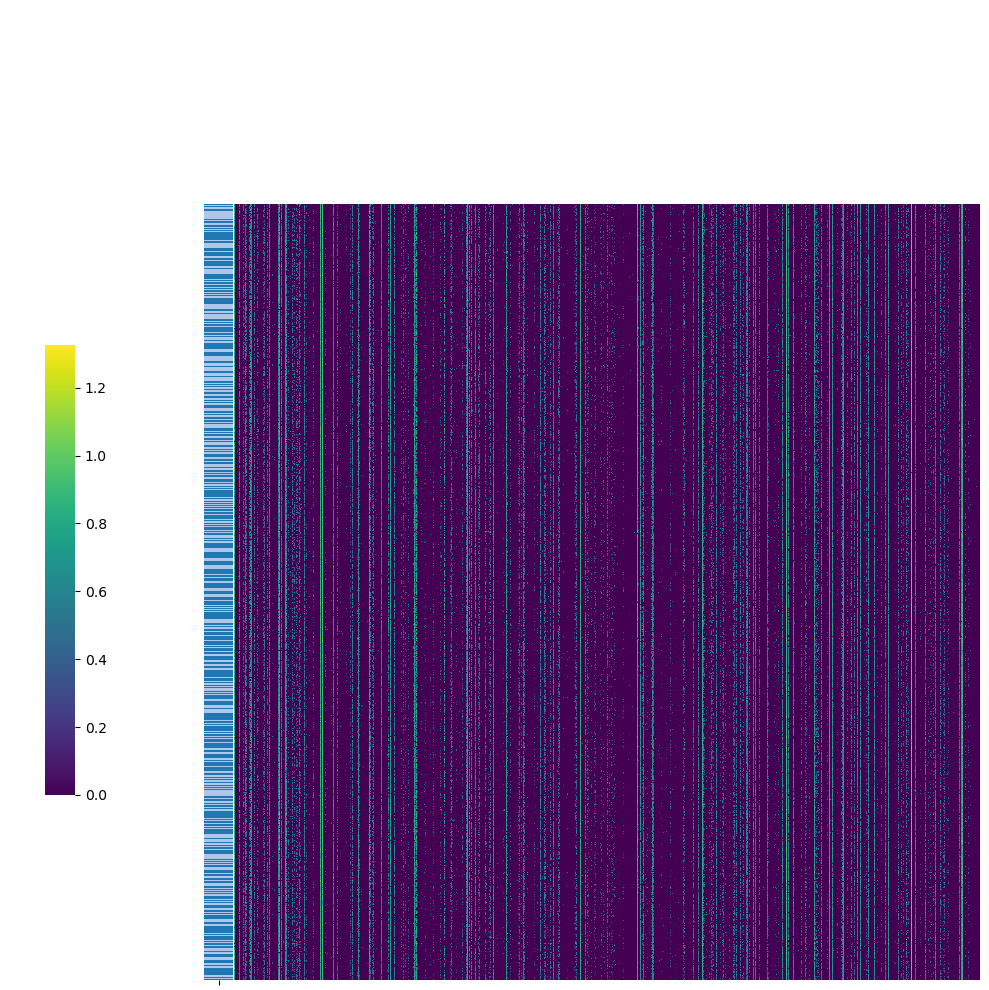

In [35]:
""" # Generate a color palette for the 'clone' categories, ensuring there are enough colors
adata_subset = ad
unique_clones = adata_subset.obs['clone'].unique()
clone_palette = sns.color_palette("tab20", n_colors=len(unique_clones))

# Map 'clone' categories to colors
clone_colors = {clone: color for clone, color in zip(unique_clones, clone_palette)}

# Apply the mapping to generate row colors for the clustermap
clone_series = adata_subset.obs['clone']
color_list = [clone_colors[clone] if clone in clone_colors else None for clone in clone_series]

# Now, color_list contains the corresponding color for each entry in clone_series
# Verify the operation by converting color_list back to a Series and inspecting it
color_series = pd.Series(color_list, index=clone_series.index)

# Create the clustermap
data_df = adata_subset.to_df()
g = sns.clustermap(data_df, method='average', metric='euclidean', 
                   figsize=(10, 10), row_cluster=False, col_cluster=False,
                   row_colors=color_series, cmap='viridis', 
                   yticklabels=False, # Often too cluttered, adjust as needed
                   xticklabels=False, # Adjust as needed
                   linewidths=0.0, rasterized=True)

# Adjust the position of the main color bar
g.cax.set_position([0.05, .2, .03, .45])

# Create a legend for the clones
for clone, color in clone_colors.items():
    g.ax_col_dendrogram.bar(0, 0, color=color, label=clone, linewidth=0)
g.ax_col_dendrogram.legend(title='Clone', loc="center", bbox_to_anchor=(0.5, -0.6), ncol=5, frameon=False)

plt.show() """

In [15]:
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 18 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 15/15 [00:00<00:00, 186.58it/s]

Selecting 5 cells from greedy initialization.


In [37]:
""" SEACells.plot.plot_initialization(ad, model) """

KeyError: 'X_umap'

<Figure size 400x400 with 0 Axes>

In [16]:
model.fit(min_iter=10, max_iter=150)

Randomly initialized A matrix.
Setting convergence threshold at 0.00059
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 38 iterations.


In [17]:
ad.obs[['SEACell']].head()
model.get_hard_assignments().to_numpy()

array([['SEACell-1'],
       ['SEACell-16'],
       ['SEACell-0'],
       ...,
       ['SEACell-6'],
       ['SEACell-16'],
       ['SEACell-6']], dtype=object)

/var/folders/r1/cc6f_cms7gs0mjjnvtnzdmcm0000gn/T/ipykernel_32782/2539960574.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


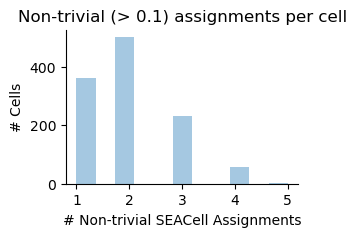

In [18]:
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

The average number of cells per seacells is 50.08695652173913


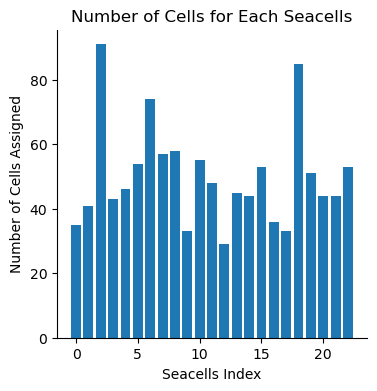

In [19]:
#labels,weights = model.get_soft_assignments()

# for each row of model.A_, find the index of the max three value:

#max_indices = model.A_.argmax(axis=1)

""" top_three_indices = np.argsort(model.A_.toarray())[:,-3:]
print(top_three_indices[145]) """
topwhich = 1
top = np.argsort(model.A_.toarray().T)[:,-topwhich:]

no_seacells = model.archetypes.shape[0]
seacells = [[] for _ in range(no_seacells)]

for i in range(0, len(top)):
    for j in top[i]:
        seacells[j].append(ad.obs_names[i])

#print(seacells[0])

# Count the number of strings in each sublist
counts = [len(sublist) for sublist in seacells]
avg = sum(counts)/len(counts)
print((f'The average number of cells per seacells is {avg}'))
# Creating a bar plot
plt.bar(range(len(counts)), counts)

# Adding title and labels
plt.title('Number of Cells for Each Seacells')
plt.xlabel('Seacells Index')
plt.ylabel('Number of Cells Assigned')

# Show the plot
plt.show()


In [20]:
ad.obs['clone']
[seacells[0]]
mode = ad.obs['clone'].loc[seacells[1]].mode()[0]
# Get the frequency of the mode for each seacell
y = ad.obs['clone'].loc[seacells[1]] == mode
frequency = y.sum()/len(seacells[1])
frequency
cell_frequency = ad.obs['clone'].value_counts(normalize=True)[0]
cell_frequency[0]

IndexError: invalid index to scalar variable.

In [21]:
sc.tl.leiden(ad, resolution=6.0)
ad.obs['leiden']

index
AAACCTGAGATGCCAG-1    23
AAACCTGTCGACAGCC-1    14
AAACCTGTCTTCAACT-1    18
AAACGGGTCGTTGCCT-1     3
AAAGATGAGTGGTAGC-1    36
                      ..
TTTGCGCTCCAAGCCG-1    14
TTTGGTTAGTAGCCGA-1     4
TTTGGTTCAGATGGCA-1    28
TTTGTCAAGCATGGCA-1    34
TTTGTCATCTATCGCC-1    28
Name: leiden, Length: 1152, dtype: category
Categories (59, object): ['0', '1', '2', '3', ..., '55', '56', '57', '58']

In [22]:

ad.obs['leiden']

no = np.unique(ad.obs['leiden']).shape[0]
# Group the cells by leiden category
leidens = [[] for _ in range(no)]

for i in range(0, len(ad.obs['leiden'])):
    leidens[int(ad.obs['leiden'][i])].append(ad.obs_names[i])

In [23]:
import random

def shuffle_list_of_lists(list_of_lists):
    # Flatten the list of lists
    flat_list = [item for sublist in list_of_lists for item in sublist]
    
    # Shuffle the flattened list
    random.shuffle(flat_list)
    
    # Recreate the list of lists with original sublist sizes
    result = []
    index = 0
    for sublist in list_of_lists:
        size = len(sublist)
        new_sublist = flat_list[index:index + size]
        result.append(new_sublist)
        index += size
        
    return result

# Example usage

shuffled_leidens = shuffle_list_of_lists(leidens)
shuffled_leidens[0]

['GAGCAGATCCTTAATC-1',
 'GGACAAGAGCAGATCG-1',
 'ATCATGGGTCTTGCGG-1',
 'GTGAAGGCATTTCAGG-1',
 'GGACAGATCTCTGCTG-1',
 'GGTGTTATCGACAGCC-1',
 'AGCGTATAGCCAGGAT-1',
 'TCGAGGCCATACTCTT-1',
 'ACGAGGATCGGCGGTT-1',
 'CGTTGGGCAGTATGCT-1',
 'TCAATCTAGCGATGAC-1',
 'CGGACTGCATGTAGTC-1',
 'TGAGCCGGTCGTCTTC-1',
 'ATAACGCAGTTGTCGT-1',
 'CCCAGTTCACCATGTA-1',
 'GCTCCTAAGTCCAGGA-1',
 'GATGCTAAGCACGCCT-1',
 'ACACCAACAGAAGCAC-1',
 'CTGCCTAGTAGCTAAA-1',
 'GGCTGGTTCACGCATA-1',
 'CATCCACGTGACCAAG-1',
 'GAAGCAGCAAACCCAT-1',
 'ACGATACTCTTCATGT-1',
 'TCGGTAAGTAAATGAC-1',
 'TGGTTAGCAATCACAC-1',
 'CTCACACGTAGCCTCG-1',
 'TTCGGTCCATGCAACT-1',
 'CTAGAGTTCGGCGCTA-1',
 'ACTGATGAGTCCATAC-1',
 'CACATAGAGTCTTGCA-1',
 'GCAAACTTCACTGGGC-1',
 'GACGCGTAGCGTGAAC-1',
 'CGTCCATTCAATAAGG-1',
 'CTACATTCATCACAAC-1',
 'TCGCGTTTCGCCCTTA-1',
 'ATCACGATCAACGGGA-1',
 'TGGCTGGAGCCACGTC-1',
 'TGCACCTAGCGGCTTC-1',
 'GAACCTACAATACGCT-1',
 'AGTTGGTTCCTTTCGG-1',
 'CACACTCCACCTATCC-1',
 'GGCTCGATCCTACAGA-1',
 'AAGGTTCGTGCCTTGG-1',
 'ACAGCCGAG

A    0.807292
B    0.166667
C    0.026042
Name: clone, dtype: float64
The weighted average modal frequency across leiden clusters is 0.8810763888888888
The weighted average modal frequency across random leiden clusters is 0.8072916666666666
The average modal frequency across leiden clusters is 0.8877338888651608
The average modal frequency across cells is 0.8072916666666666
The average modal frequency across random leiden clusters is 0.80502961761353


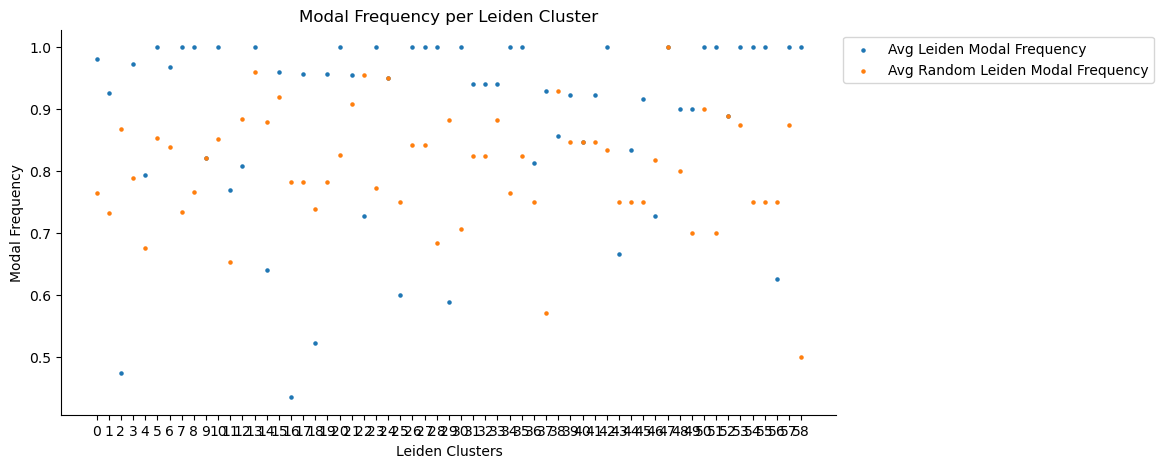

[0.9803921568627451, 0.926829268292683, 0.47368421052631576, 0.9736842105263158, 0.7941176470588235, 1.0, 0.967741935483871, 1.0, 1.0, 0.8214285714285714, 1.0, 0.7692307692307693, 0.8076923076923077, 1.0, 0.64, 0.96, 0.43478260869565216, 0.9565217391304348, 0.5217391304347826, 0.9565217391304348, 1.0, 0.9545454545454546, 0.7272727272727273, 1.0, 0.95, 0.6, 1.0, 1.0, 1.0, 0.5882352941176471, 1.0, 0.9411764705882353, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0, 0.8125, 0.9285714285714286, 0.8571428571428571, 0.9230769230769231, 0.8461538461538461, 0.9230769230769231, 1.0, 0.6666666666666666, 0.8333333333333334, 0.9166666666666666, 0.7272727272727273, 1.0, 0.9, 0.9, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.625, 1.0, 1.0]
[0.7647058823529411, 0.7317073170731707, 0.868421052631579, 0.7894736842105263, 0.6764705882352942, 0.8529411764705882, 0.8387096774193549, 0.7333333333333333, 0.7666666666666667, 0.8214285714285714, 0.8518518518518519, 0.6538461538461539, 0.8846153846153846, 0

In [24]:
no_leidens = np.unique(ad.obs['leiden']).shape[0] 
frequencies = []
# Assuming all_cnas is your DataFrame and seacells[0] is the list of columns
# Calculate the mode for each row
for i in range(0, no_leidens):
    mode = ad.obs['clone'].loc[leidens[i]].mode()[0]
    y = ad.obs['clone'].loc[leidens[i]] == mode
    frequency = y.sum()/len(leidens[i])
    frequencies.append(frequency)

random_frequencies = []
for i in range(0, no_leidens):
    mode = ad.obs['clone'].loc[shuffled_leidens[i]].mode()[0]
    y = ad.obs['clone'].loc[shuffled_leidens[i]] == mode
    frequency = y.sum()/len(shuffled_leidens[i])
    random_frequencies.append(frequency)

cell_frequency = ad.obs['clone'].value_counts(normalize=True)[0]
print(ad.obs['clone'].value_counts(normalize=True))

mean_leiden_frequency = sum(frequencies)/len(frequencies)
mean_random_leiden_frequency = sum(random_frequencies)/len(random_frequencies)

# weighted average of the frequencies
weighted_mean_leiden_frequency = sum([frequencies[i]*len(leidens[i]) for i in range(len(leidens))])/sum([len(leidens[i]) for i in range(len(leidens))])
weighted_random_mean_leiden_frequency = sum([random_frequencies[i]*len(shuffled_leidens[i]) for i in range(len(shuffled_leidens))])/sum([len(shuffled_leidens[i]) for i in range(len(shuffled_leidens))])

print(f"The weighted average modal frequency across leiden clusters is {weighted_mean_leiden_frequency}")
print(f"The weighted average modal frequency across random leiden clusters is {weighted_random_mean_leiden_frequency}")

print(f"The average modal frequency across leiden clusters is {mean_leiden_frequency}")
print(f"The average modal frequency across cells is {cell_frequency}")
print(f"The average modal frequency across random leiden clusters is {mean_random_leiden_frequency}")


# scatter the frequencies
plt.figure(figsize=(10,5))
plt.scatter(range(len(frequencies)), frequencies, s=5, label='Avg Leiden Modal Frequency')
plt.scatter(range(len(random_frequencies)), random_frequencies, s=5, label='Avg Random Leiden Modal Frequency')
plt.title('Modal Frequency per Leiden Cluster')
plt.xlabel('Leiden Clusters')
plt.ylabel('Modal Frequency')
plt.xticks(range(len(frequencies)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(frequencies)
print(random_frequencies)

In [25]:
ad.obs['leiden'][0]
ad.obs_names[0]
ad.obs['leiden']

index
AAACCTGAGATGCCAG-1    23
AAACCTGTCGACAGCC-1    14
AAACCTGTCTTCAACT-1    18
AAACGGGTCGTTGCCT-1     3
AAAGATGAGTGGTAGC-1    36
                      ..
TTTGCGCTCCAAGCCG-1    14
TTTGGTTAGTAGCCGA-1     4
TTTGGTTCAGATGGCA-1    28
TTTGTCAAGCATGGCA-1    34
TTTGTCATCTATCGCC-1    28
Name: leiden, Length: 1152, dtype: category
Categories (59, object): ['0', '1', '2', '3', ..., '55', '56', '57', '58']

In [26]:
import random

def shuffle_list_of_lists(list_of_lists):
    # Flatten the list of lists
    flat_list = [item for sublist in list_of_lists for item in sublist]
    
    # Shuffle the flattened list
    random.shuffle(flat_list)
    
    # Recreate the list of lists with original sublist sizes
    result = []
    index = 0
    for sublist in list_of_lists:
        size = len(sublist)
        new_sublist = flat_list[index:index + size]
        result.append(new_sublist)
        index += size
        
    return result

# Example usage

shuffled_seacells = shuffle_list_of_lists(seacells)
shuffled_seacells[0]

['ACCCACTGTACACCGC-1',
 'CGAACATCACGTCAGC-1',
 'TCAATCTAGGCCCTCA-1',
 'GCATACATCTTTACAC-1',
 'CTCAGAATCACGATGT-1',
 'ACATCAGGTTAAGAAC-1',
 'TTCCCAGAGCCCAGCT-1',
 'CTAGTGAAGATAGTCA-1',
 'GACGTGCAGACACTAA-1',
 'GTGTGCGAGATCGATA-1',
 'GGAACTTTCGCCTGTT-1',
 'TCTCATACACACCGCA-1',
 'TCTGAGATCCTCAATT-1',
 'ATCCACCGTCATATCG-1',
 'CCACGGAAGCGGCTTC-1',
 'ACGTCAACAGAAGCAC-1',
 'AAACCTGTCGACAGCC-1',
 'GCTTCCACACGAAGCA-1',
 'CCAATCCGTGGTGTAG-1',
 'GTGTTAGGTATATCCG-1',
 'ACGTCAATCAGCCTAA-1',
 'TCAGATGAGTGTACGG-1',
 'TGCCCATAGACACTAA-1',
 'CATGACACATGGTTGT-1',
 'AAACCTGTCTTCAACT-1',
 'GACGCGTAGCGTGAAC-1',
 'TCATTTGTCTAGAGTC-1',
 'CCGGGATTCCCTAATT-1',
 'CTGCGGAAGTCCATAC-1',
 'GCTTGAATCAATCTCT-1',
 'AGAGCTTTCAACGGGA-1',
 'AGCGTATTCTTGCATT-1',
 'AGCATACAGTATCGAA-1',
 'AAGGTTCTCTGTCTAT-1',
 'CGAATGTCATTACGAC-1']

The weighted average modal frequency across seacells and genomic regions is 0.8715277777777778
The weighted average modal frequency across random seacells and genomic regions is 0.8072916666666666
The average modal frequency across seacells and genomic regions is 0.8731575905996394
The average modal frequency across cells and genomic regions is 0.8072916666666666
The average modal frequency across random seacells and genomic regions is 0.796841216336125


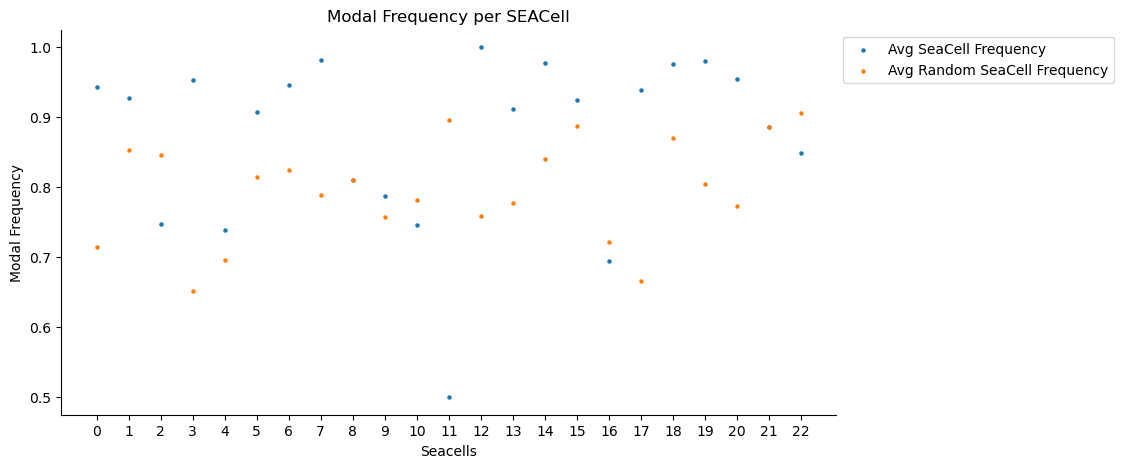

[0.9428571428571428, 0.926829268292683, 0.7472527472527473, 0.9534883720930233, 0.7391304347826086, 0.9074074074074074, 0.9459459459459459, 0.9824561403508771, 0.8103448275862069, 0.7878787878787878, 0.7454545454545455, 0.5, 1.0, 0.9111111111111111, 0.9772727272727273, 0.9245283018867925, 0.6944444444444444, 0.9393939393939394, 0.9764705882352941, 0.9803921568627451, 0.9545454545454546, 0.8863636363636364, 0.8490566037735849]
[0.7142857142857143, 0.8536585365853658, 0.8461538461538461, 0.6511627906976745, 0.6956521739130435, 0.8148148148148148, 0.8243243243243243, 0.7894736842105263, 0.8103448275862069, 0.7575757575757576, 0.7818181818181819, 0.8958333333333334, 0.7586206896551724, 0.7777777777777778, 0.8409090909090909, 0.8867924528301887, 0.7222222222222222, 0.6666666666666666, 0.8705882352941177, 0.803921568627451, 0.7727272727272727, 0.8863636363636364, 0.9056603773584906]


In [28]:
no_seacells = model.archetypes.shape[0]
frequencies = []
# Assuming all_cnas is your DataFrame and seacells[0] is the list of columns
# Calculate the mode for each row
for i in range(0, no_seacells):
    mode = ad.obs['clone'].loc[seacells[i]].mode()[0]
    y = ad.obs['clone'].loc[seacells[i]] == mode
    frequency = y.sum()/len(seacells[i])
    frequencies.append(frequency)

random_frequencies = []
for i in range(0, no_seacells):
    mode = ad.obs['clone'].loc[shuffled_seacells[i]].mode()[0]
    y = ad.obs['clone'].loc[shuffled_seacells[i]] == mode
    frequency = y.sum()/len(seacells[i])
    random_frequencies.append(frequency)

cell_frequency = ad.obs['clone'].value_counts(normalize=True)[0]

mean_seacell_frequency = sum(frequencies)/len(frequencies)
mean_random_seacell_frequency = sum(random_frequencies)/len(random_frequencies)

# weighted average of the frequencies
weighted_mean_seacell_frequency = sum([frequencies[i]*len(seacells[i]) for i in range(len(seacells))])/sum([len(seacells[i]) for i in range(len(seacells))])
weighted_random_mean_seacell_frequency = sum([random_frequencies[i]*len(shuffled_seacells[i]) for i in range(len(shuffled_seacells))])/sum([len(shuffled_seacells[i]) for i in range(len(shuffled_seacells))])

print(f"The weighted average modal frequency across seacells and genomic regions is {weighted_mean_seacell_frequency}")
print(f"The weighted average modal frequency across random seacells and genomic regions is {weighted_random_mean_seacell_frequency}")

print(f"The average modal frequency across seacells and genomic regions is {mean_seacell_frequency}")
print(f"The average modal frequency across cells and genomic regions is {cell_frequency}")
print(f"The average modal frequency across random seacells and genomic regions is {mean_random_seacell_frequency}")


# scatter the frequencies
plt.figure(figsize=(10,5))
plt.scatter(range(len(frequencies)), frequencies, s=5, label='Avg SeaCell Frequency')
plt.scatter(range(len(random_frequencies)), random_frequencies, s=5, label='Avg Random SeaCell Frequency')
plt.title('Modal Frequency per SEACell')
plt.xlabel('Seacells')
plt.ylabel('Modal Frequency')
plt.xticks(range(len(frequencies)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(frequencies)
print(random_frequencies)
